In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn import preprocessing
from sklearn import decomposition
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import extract_features
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Here, we use L2 norm as the element comparison distance
l2_norm = lambda x, y: (x - y) ** 2


def slide_window(time_series, window_size, cur_loc=0, step=1):
    # print('Sliding Started')
    window_contents = []
    ts_len = len(time_series)
    while cur_loc + window_size <= ts_len:
        # print(time_series[cur_loc:cur_loc + window_size])
        window_contents.append(time_series[cur_loc:cur_loc + window_size])
        cur_loc += step
    # print('Sliding Completed')
    return window_contents


def find_signature_cycle(ts_list, num_consider=5):
    zip_ts = zip([len(ts) for ts in ts_list], ts_list)
    zip_ts = sorted(zip_ts, key=lambda x: x[0])
    length, ts_list_sorted = zip(*zip_ts)
    # print(length)
    signature = []
    short_ts = list(ts_list_sorted[:num_consider])
    len_limit = length[num_consider - 1]
    # print(len_limit)
    for i in range(len_limit):
        vertical_data_points = []
        for ts in short_ts:
            # print(ts)
            if i < len(ts):
                vertical_data_points.append(ts[i])
        avg = sum(vertical_data_points) / len(vertical_data_points)
        signature.append(avg)
    plt.plot(signature, color='k', label='avg signature cycle')
    plt.legend()
    return signature


def find_train_set_signature(train_file_name, label_name, num_cycles=10):
    df = pd.read_csv(train_file_name)
    df_all_cycles = df[df['label'] == label_name]
    ts_all = df['value']

    cycle_id = None
    ts_list = []
    ts = [0]
    for i in range(len(df_all_cycles)):
        row = df_all_cycles.iloc[i, :]
        val = row['value']
        if row['cycle_id'] != cycle_id:
            plt.plot(ts, alpha=0.6)
            ts_list.append(ts)
            ts = []
            cycle_id = row['cycle_id']
            ts.append(val)
        else:
            ts.append(val)
    
    signature = find_signature_cycle(ts_list, num_consider=num_cycles)
    return signature
    


def sliding_window_dtw(all_window_contents, signature):
    dist_list = []
    path_list = []
    marker_1 = []
    marker_2 = []
    for slide in all_window_contents:
        # print(slide.tolist())
        slide_l = slide.tolist()
        dist, cost_matrix, acc_cost_matrix, path = dtw(signature, slide_l, dist=l2_norm)
        path_list.append(path)
        dist_list.append(dist)
    return dist_list, path_list


def split_train_test(X, y, pca=False):
    if pca:
        extract_features_normalized = preprocessing.normalize(X)

        pca = decomposition.PCA(n_components=len(extract_features_normalized))
        principalComponents = pca.fit_transform(extract_features_normalized)
        principalDf = pd.DataFrame(data=principalComponents)
        print('cumulative sums of explained variance ratio:')
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        print(cumsum)

        n_components = next(x for x, val in enumerate(cumsum) if val > 0.97) + 1
        print('To make explained variance ratio >= 0.97, \
         we choose n_components of PCA to be:', n_components)

        pca_ = decomposition.PCA(n_components=n_components)
        principalComponents_ = pca_.fit_transform(extract_features_normalized)
        X = pd.DataFrame(data=principalComponents_)
        # print('shape of reduced extract features is: ', principalDf_.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, random_state=0)
    return X_train, y_train, X_test, y_test


def test_feature_extract(df, target_name='A',
                         value_column='value', id_column='cycle_id',
                         time_column='time_index'):
    from tsfresh.feature_extraction import ComprehensiveFCParameters
    from tsfresh.feature_extraction import extract_features
    from tsfresh import extract_relevant_features

    # Select columns
    df_ = df[[value_column, id_column, time_column]]

    # tsfresh feature extraction
    df_.sort_values(by=['time_index'])
    features_delta = extract_features(df_.drop(columns=[time_column]),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id=id_column)

    # delete columns with inf value
    valid_column = list(np.isfinite(features_delta).all())
    # X = features_delta.iloc[:, valid_column]
    # X.replace([np.inf, -np.inf], np.nan, inplace=True)
    # X = X.fillna(0, inplace=True)

    X = features_delta

    return X, valid_column


def train_feature_extract(file_name, target_name='A', label_column='label',
                          value_column='value', id_column='cycle_id',
                          time_column='time_index', ):
    from tsfresh.feature_extraction import ComprehensiveFCParameters
    from tsfresh.feature_extraction import extract_features
    from tsfresh import extract_relevant_features

    df = pd.read_csv(file_name)
    # Select columns
    df_ = df[[label_column, value_column, id_column, time_column]]

    # tsfresh feature extraction
    df_.sort_values(by=['time_index'])
    features_delta = extract_features(df_.drop(columns=[label_column, time_column]),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id=id_column)
    # Get 0,1 labels
    grouped = df_.groupby([id_column])
    labels = grouped.first()[label_column]
    labels = [1 if x == target_name else 0 for x in labels]

    # delete columns with inf value
    valid_column = list(np.isfinite(features_delta).all())
    # features_delta = features_delta.iloc[:, valid_column]

    X = features_delta
    y = labels

    return X, y, valid_column


def train_decision_tree(X_train, y_train, X_test, y_test):
    # Cross Validation
    clf = tree.DecisionTreeClassifier(max_depth=5)
    param_grid = {"max_depth": [3, 4, 5, 6, 7, 8]}

    grid_search2 = GridSearchCV(clf, param_grid=param_grid,
                                scoring='accuracy', cv=5,
                                return_train_score=True)
    grid_search2.fit(X_train, y_train)
    print("Scores on validation set:")
    means = grid_search2.cv_results_['mean_test_score']
    stds = grid_search2.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,
                                 grid_search2.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print(grid_search2.best_params_)

    # Return model with best hyper parameters
    print('==============================')
    clf = tree.DecisionTreeClassifier(max_depth=grid_search2.best_params_['max_depth'])
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print('Scores on testing set:', score)
    return clf


def train_random_forest(X_train, y_train, X_test, y_test):
    # Create Random Forest Regressor object
    rf = RandomForestClassifier(random_state=10)

    param_grid = {"criterion": ['entropy', 'gini'],
                  "n_estimators": [10, 20],
                  "max_depth": [3, 5, 7, 10]}

    grid_search = GridSearchCV(rf, param_grid=param_grid,
                               scoring='accuracy', cv=10,
                               return_train_score=True)
    grid_search.fit(X_train, y_train)

    print("Scores on validation set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,
                                 grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print(grid_search.best_params_)

    # Return model with best hyper parameters
    print('==============================')
    rf = RandomForestClassifier(criterion=grid_search.best_params_['criterion'],
                                n_estimators=grid_search.best_params_['n_estimators'],
                                max_depth=grid_search.best_params_['max_depth'])
    rf = rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    print('Scores on testing set:', score)
    return rf


def train_decision_tree_no_test(X_train, y_train):
    # Cross Validation
    clf = tree.DecisionTreeClassifier()
    param_grid = {"max_depth": [3, 4, 5, 6, 7, 8]}

    grid_search2 = GridSearchCV(clf, param_grid=param_grid,
                                scoring='accuracy', cv=5,
                                return_train_score=True)
    
    grid_search2.fit(X_train, y_train)
    print("Train decision tree...:")
    print("Scores on validation set:")
    means = grid_search2.cv_results_['mean_test_score']
    stds = grid_search2.cv_results_['std_test_score']
    
#     for mean, std, params in zip(means, stds,
#                                  grid_search2.cv_results_['params']):
# #         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print('Validation Results -- grid search best parameters: ', grid_search2.best_params_)
    
    clf = tree.DecisionTreeClassifier(max_depth=grid_search2.best_params_['max_depth'])
    clf = clf.fit(X_train, y_train)
    return clf


def train_random_forest_no_test(X_train, y_train):
    # Create Random Forest Regressor object
    rf = RandomForestClassifier(random_state=10)

    param_grid = {"criterion": ['entropy', 'gini'],
                  "n_estimators": [10, 20],
                  "max_depth": [3, 5, 7, 10]}

    grid_search = GridSearchCV(rf, param_grid=param_grid,
                               scoring='accuracy', cv=5,
                               return_train_score=True)
    
    grid_search.fit(X_train, y_train)
#     print("Train random forest...:")
#     print("Scores on validation set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds,
#                                  grid_search.cv_results_['params']):
# #         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print('Validation Results -- grid search best parameters: ', grid_search.best_params_)

    # Return model with best hyper parameters
#     print('==============================')
    rf = RandomForestClassifier(criterion=grid_search.best_params_['criterion'],
                                n_estimators=grid_search.best_params_['n_estimators'],
                                max_depth=grid_search.best_params_['max_depth'])
    rf = rf.fit(X_train, y_train)
    return rf


def construct_cycle_id(ts_list):
    rep_times = [len(ts) for ts in ts_list]
    cycle_id = []
    id_ = 0
    for i in rep_times:
        cycle_id.append([id_] * i)
        id_ += 1
    cycle_id = [i for j in cycle_id for i in j]
    return cycle_id




def sliding_window_find_dist(file_name, label_name, signature, generate_plots=False):
    df = pd.read_csv(file_name)
    df_all_cycles = df[df['label'] == label_name]
    ts_all = df['value']

    all_window_contents = slide_window(ts_all, 45, step=1)

    dist_list, path_list = sliding_window_dtw(all_window_contents, signature)

    grouped = df_all_cycles.groupby(['cycle_id'])
    cycle_labels = grouped.first()['time_index']
    cycle_labels_2 = grouped.last()['time_index']

    if generate_plots:
        plt.figure(figsize=(60, 5))
        plt.plot(dist_list[:], label='distance to signature cycle')
        plt.plot(ts_all[:], color='k', label='input time series')
        plt.ylim(-2, 8)
        start = cycle_labels.tolist()
        end = cycle_labels_2.tolist()
        for i in cycle_labels:
            plt.axvline(i, 0, 14, linestyle='--', color='r')
        for i in range(len(start)):
            # alpha: 透明度
            # i+.5 -- 宽度
            plt.axvspan(start[i], end[i], facecolor='r', alpha=0.3)
        plt.legend()

    return ts_all, all_window_contents, dist_list, path_list, \
           cycle_labels, cycle_labels_2


def sliding_window_classifier(all_window_contents, dist_list, train_file_name,
                              target_name, dtw_threshold,
                              classifier='rf', predict_type='proba'):
    # Step 0: remove all partial time series if dist > dtw_threshold
    #         we only do classification on valid pieces
    #         - where dist is smaller than threshold
    index_list = [i for i, bol in enumerate([i < dtw_threshold for i in dist_list]) if bol]
    valid_pieces = [all_window_contents[i] for i in index_list]

    # Preprocess windowcontents into the df
    # as the input of extract_features
    valid_pieces_flatten = [item for sublist in valid_pieces for item in sublist]
    cycle_id = construct_cycle_id(valid_pieces)
    df_test = pd.DataFrame({'time_index': [i for i in range(len(valid_pieces_flatten))],
                            'value': valid_pieces_flatten,
                            'cycle_id': cycle_id})

    # Step 1: feature extraction on test dataset
    features_delta = extract_features(df_test.drop(columns=['time_index']),
                                      default_fc_parameters=ComprehensiveFCParameters(),
                                      column_id='cycle_id')

    # Step 2: preprocess train and test set. find all invalid columns, and remove
    #         them from both train and test sets.
    X_test = features_delta
    valid_column_test = list(np.isfinite(features_delta).all())

    X_train, y_train, valid_column_train = train_feature_extract(train_file_name,
                                                                 target_name=target_name)
    valid_column = np.logical_and(valid_column_train, valid_column_test)

    X_train = X_train.iloc[:, valid_column]
    X_test = X_test.iloc[:, valid_column]

    # Step 3: train model/classifier on training set
    if classifier == 'rf':
        print('Training random forest classifier...')
        model = train_random_forest_no_test(X_train, y_train)
    elif classifier == 'clf':
        print('Training decision tree classifier...')
        model = train_decision_tree_no_test(X_train, y_train)
    else: 
        print('classifier type not availabel.')
        return 'Select classifier rf or clf'

    # step 4: calculate prediction
    print('Calculating prediction... prediction type: ', predict_type)
    if predict_type == 'proba':
        model_pred = model.predict_proba(X_test)[:, 1]

    elif predict_type == 'binary':
        model_pred = model.predict(X_test)

#     print(len(model_pred))
#     print(model_pred)
#     print(np.mean(model_pred))

    total_len = len(dist_list)
    proba_list = [0] * total_len

    for i in index_list:
        proba_list[i] = model_pred[0]
        model_pred = model_pred[1:]

    return proba_list


def find_dtw_threshold(dist_list, percentile):
#     plt.hist(dist_list, bins=20)
#     plt.show()
    suggested_threshold = np.percentile(dist_list, percentile)
    return suggested_threshold


def plot_result(dist_list, ts_all, proba_list, threshold, cycle_start, cycle_end):
    plt.figure(figsize=(60, 5))
    plt.plot(dist_list[:], label='distance to signature cycle')
    plt.plot(ts_all[:], color='k', label='input time series')
    plt.plot(np.array(proba_list) * 10, color='g', label='random forest proba to be cycle')
    start = cycle_start.tolist()
    end = cycle_end.tolist()
    for i in cycle_start:
        plt.axvline(i, 0, 14, linestyle='--', color='r')
    for i in range(len(start)):
        # alpha: 透明度
        # i+.5 -- 宽度
        plt.axvspan(start[i], end[i], facecolor='r', alpha=0.15)
    plt.axhline(threshold, 0, 14, linestyle='--', label='dtw 50 percentile threshold')
    plt.axhline(10, 0, 14, linestyle='dotted', color='g', label='max confidence(x10)')
    plt.legend()
    
    plt.figure(figsize=(60, 5))
    plt.plot(dist_list[:], label='distance to signature cycle')
    plt.plot(ts_all[:], color='k', label='input time series')
    plt.plot(np.array(proba_list) * 10, color='g', label='random forest proba to be cycle')
    start = cycle_start.tolist()
    end = cycle_end.tolist()
    for i in cycle_start:
        plt.axvline(i, 0, 14, linestyle='--', color='r', alpha=0.0 )
    for i in range(len(start)):
        plt.axvspan(start[i], end[i], facecolor='r', alpha=0.0)
    plt.axhline(threshold, 0, 14, linestyle='--', label='dtw 50 percentile threshold')
    plt.axhline(10, 0, 14, linestyle='dotted', color='g', label='max confidence(x10)')
    plt.legend()


# Main Function
def run_model(train_file_name, test_file_name,
              target_name, dtw_filter_percentile=50,
              generate_report=True, generate_plot=True):
    
    print('Find signature cycle from training set ...')
    signature = find_train_set_signature(train_file_name, target_name)
    
    print('Sliding window on testing time series ...')
    print('Calculating DTW distance')
    sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
    ts_all = sliding_window_results[0]
    all_window_contents = sliding_window_results[1]
    dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
    cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]
    
    print('Looking for DTW distance threshold ...')
    print('percentile:', dtw_filter_percentile)
    suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)
    
    print('Converting time series to features by feature extraction...')
    proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                           train_file_name, target_name,
                                           suggested_threshold)

    plot_result(dist_list, ts_all, proba_list,
                suggested_threshold, cycle_start, cycle_end)

    

def find_local_max(proba_list, threshold, range_filter):
    proba_list_ = [0] * range_filter + proba_list + [0] * range_filter
    predicted_cycle_start, _ = find_peaks(proba_list_, height=threshold, distance=range_filter)
    plt.figure(figsize=(35, 3))
    plt.plot(proba_list, color='g', alpha=0.6)
    predicted_cycle_start = [x - range_filter for x in predicted_cycle_start]
    for i in predicted_cycle_start:
        plt.axvline(i, 0, 14, color='b')
    plt.show()
    return predicted_cycle_start


def true_positive(predicted_cycle, true_cycle, interval=5):
    print('number of predicted cycles: ',len(predicted_cycle))
    print('number of real cycles: ', len(true_cycle))

    correct_predict_cycle=0
    correct_prediction = []
    for cycle in true_cycle:
        #print(cycle)
        accept_list = np.linspace(cycle-interval, cycle+interval, 2*interval+1)
        #print(accept_list)
        for prediction in predicted_cycle:
            #print(prediction)
            if prediction in accept_list:
                correct_predict_cycle += 1
                #print(correct_predict_cycle, ':')
                #print('prediction:', prediction, 'true:', cycle)
                correct_prediction.append(prediction)
    #     i = 0
    #     while predicted_cycle[i] < cycle-interval or predicted_cycle[i] > cycle+interval:
    #         if i < len(predicted_cycle):
    #             i += 1
    #         else:
    #             break
    #         if i < len(predicted_cycle):
    #             predicted_cycle = np.delete(predicted_cycle, i, 0)
    #             print(predicted_cycle)

    print('True Positive:', correct_predict_cycle/len(true_cycle))
    return correct_predict_cycle/len(true_cycle)


def false_positive(predicted_cycle, true_cycle, interval=5):
    mistake=0
    wrong_prediction = []
    for prediction in predicted_cycle:
        #print(cycle)
        accept_list = np.linspace(prediction-interval, 
                                  prediction+interval, 2*interval+1)
        correspond = 0
        for cycle in true_cycle:
            if cycle in accept_list:
                correspond = 1
        if correspond == 0:
            mistake += 1
            wrong_prediction.append(prediction)

    #     i = 0
    #     while predicted_cycle[i] < cycle-interval or predicted_cycle[i] > cycle+interval:
    #         if i < len(predicted_cycle):
    #             i += 1
    #         else:
    #             break
    #         if i < len(predicted_cycle):
    #             predicted_cycle = np.delete(predicted_cycle, i, 0)
    #             print(predicted_cycle)

    print('False Positive:', mistake/len(predicted_cycle))
    return  mistake/len(predicted_cycle)

def plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list):
    l = len(ts_all)
    fig = plt.figure(figsize=((l/3000)*35, 3))
    ax = fig.add_subplot(111)

    ax.plot(ts_all, color='k', label='time series')
    ax.plot(dist_list,alpha=0)

    plt.axvline(predicted_cycle[0], 0, 14, color='b', label='prediction')
    plt.axvline(true_cycle[0], 0, 14, color='r', label='true')

    for i in predicted_cycle[1:]:
        plt.axvline(i, 0, 14, color='b')
    for j in true_cycle[1:]:
        plt.axvline(j, 0, 14, color='r')
    ax2 = ax.twinx()
    ax2.plot(proba_list, color = 'g', label='proba of cycle', alpha=0.7)
    ax2.set_ylabel(r"proba of cycle", color='g')

    ax.set_xlabel("x [units]")
    ax.set_ylabel(r"time series input")
    #ax.spines['left'].set_color('b')
    fig.legend(loc='upper right')
    #ax2.spines['right'].set_color('g')
    plt.show()

## Cycle Pattern A

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...



Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.72it/s]

Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


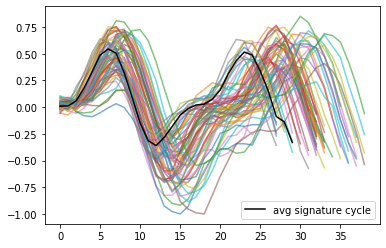

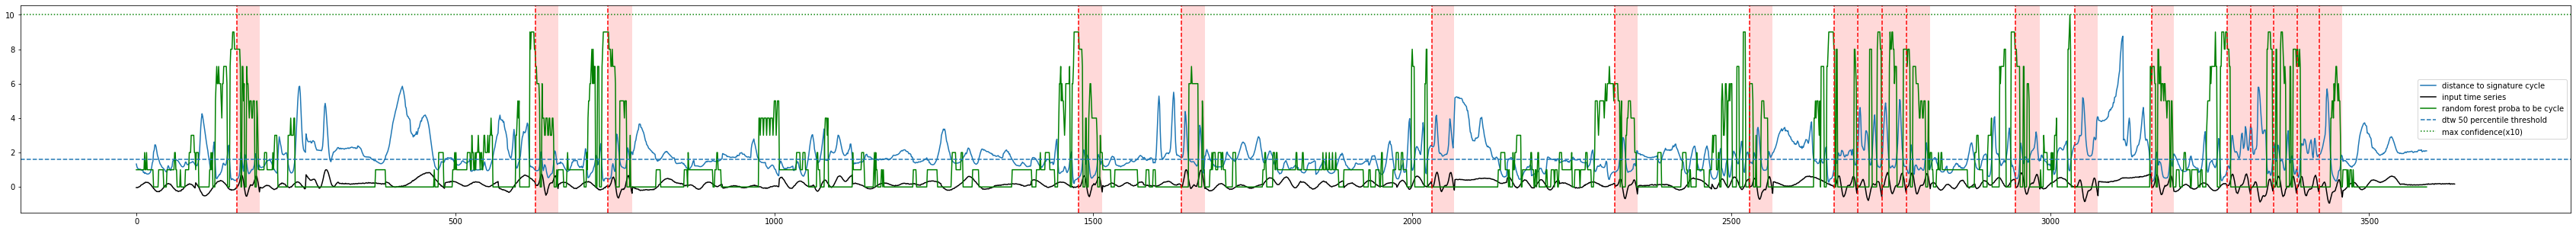

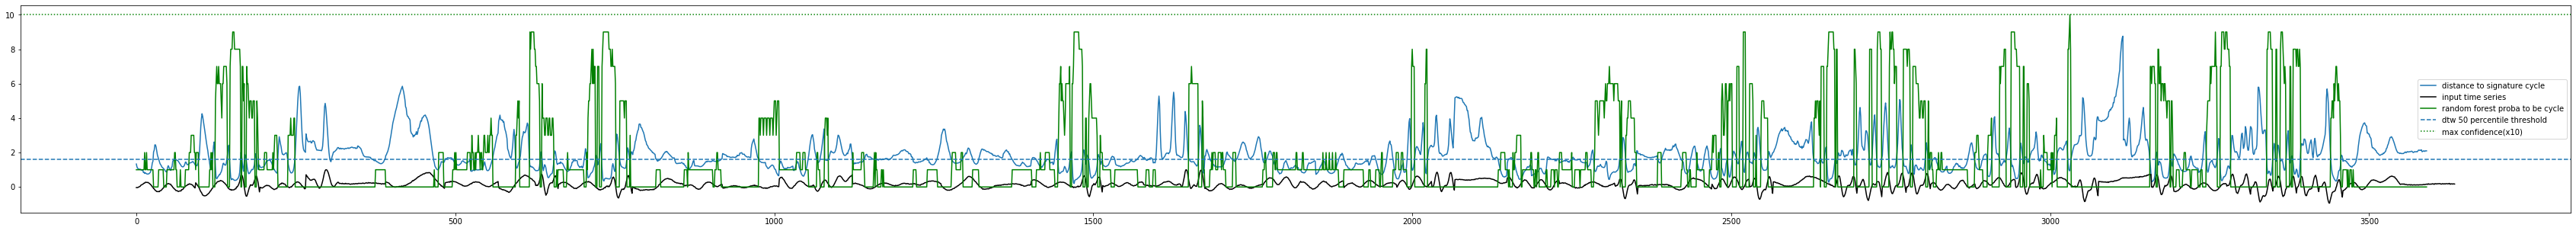

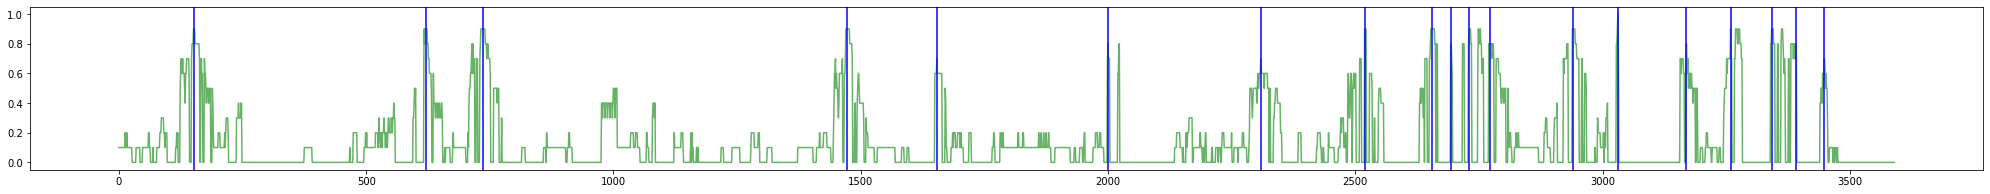

number of predicted cycles:  19
number of real cycles:  20
True Positive: 0.75
False Positive: 0.21052631578947367


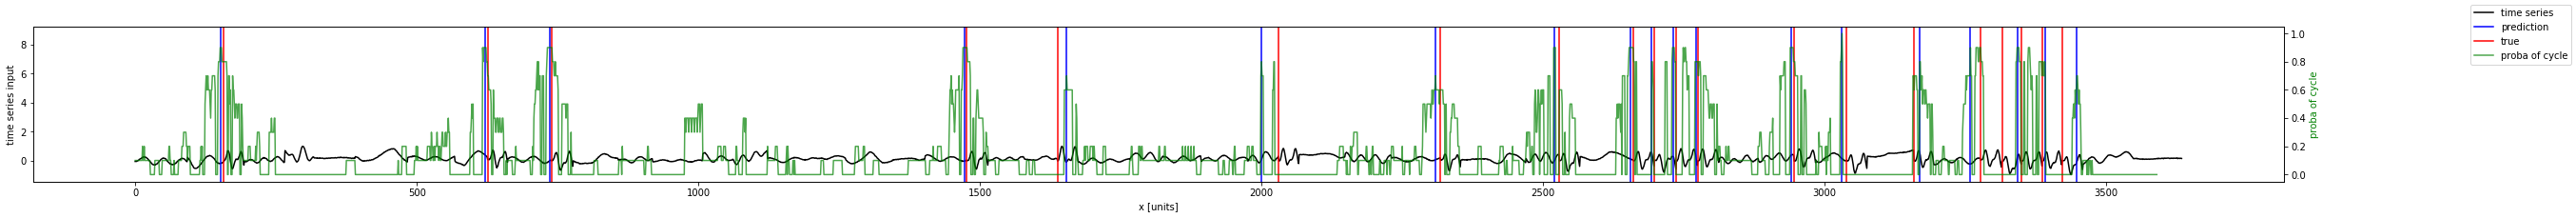

In [94]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'A_train_1.csv' 
test_file_name = 'A_test_1.csv'
target_name = 'A'
dtw_filter_percentile = 50

print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.7
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=15)
fp = false_positive(predicted_cycle, true_cycle, interval=15)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...



Feature Extraction: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


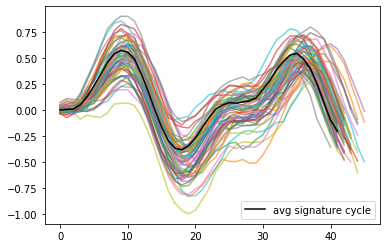

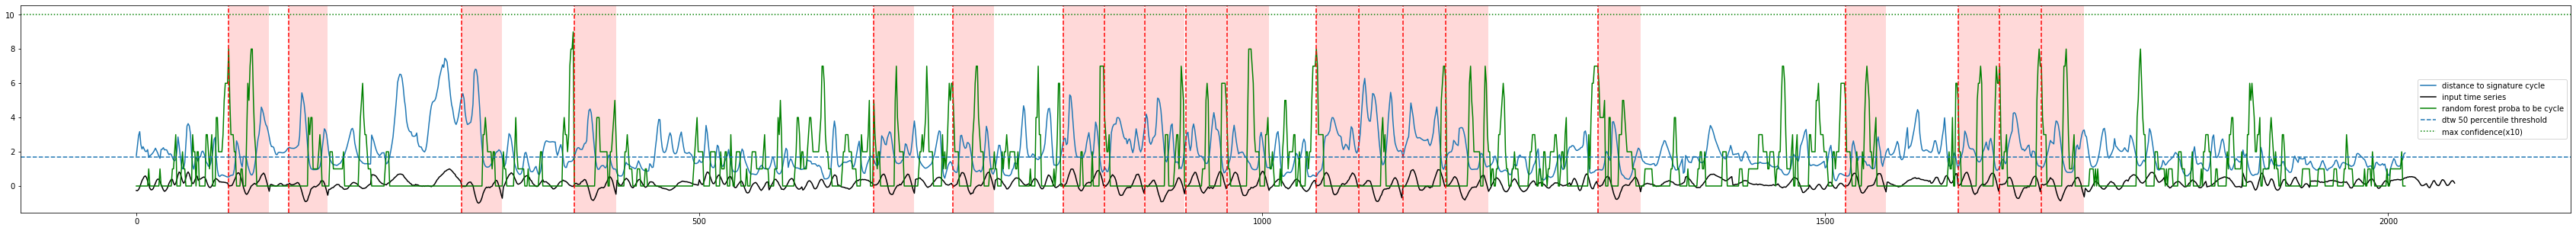

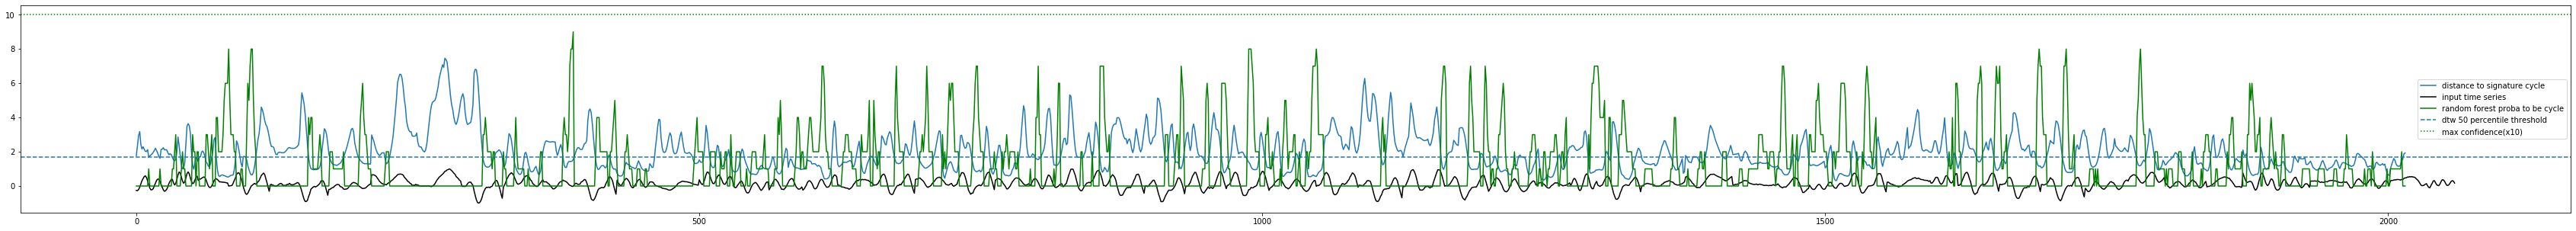

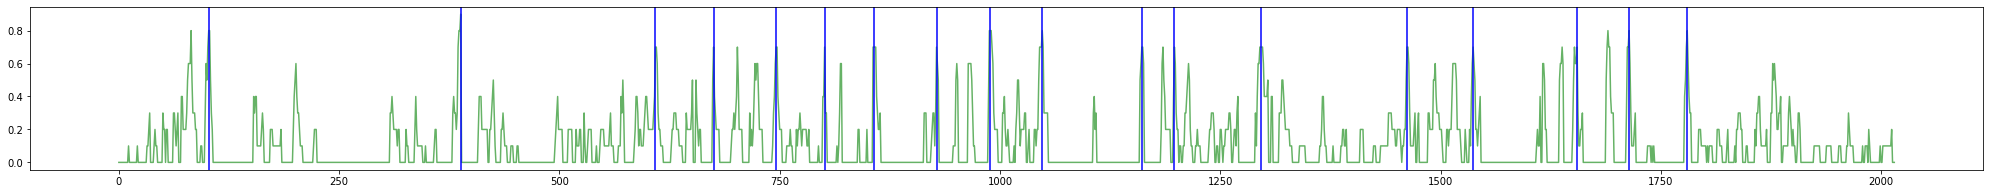

number of predicted cycles:  18
number of real cycles:  20
True Positive: 0.35
False Positive: 0.6111111111111112


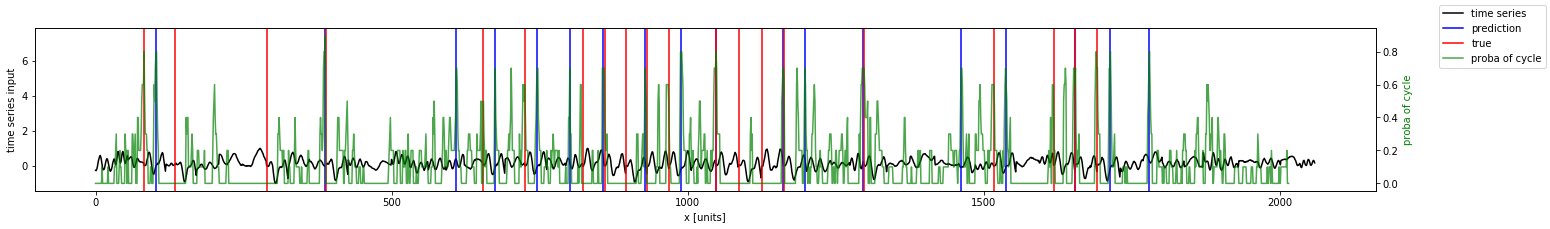

In [95]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'A_train_2.csv' 
test_file_name = 'A_test_2.csv'
target_name = 'A'
dtw_filter_percentile = 50

print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.7
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=15)
fp = false_positive(predicted_cycle, true_cycle, interval=15)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

## Cycle Pattern B

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...



Feature Extraction: 100%|██████████| 10/10 [00:07<00:00,  1.58it/s]

Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


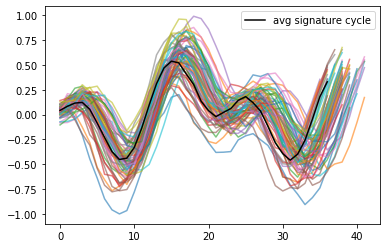

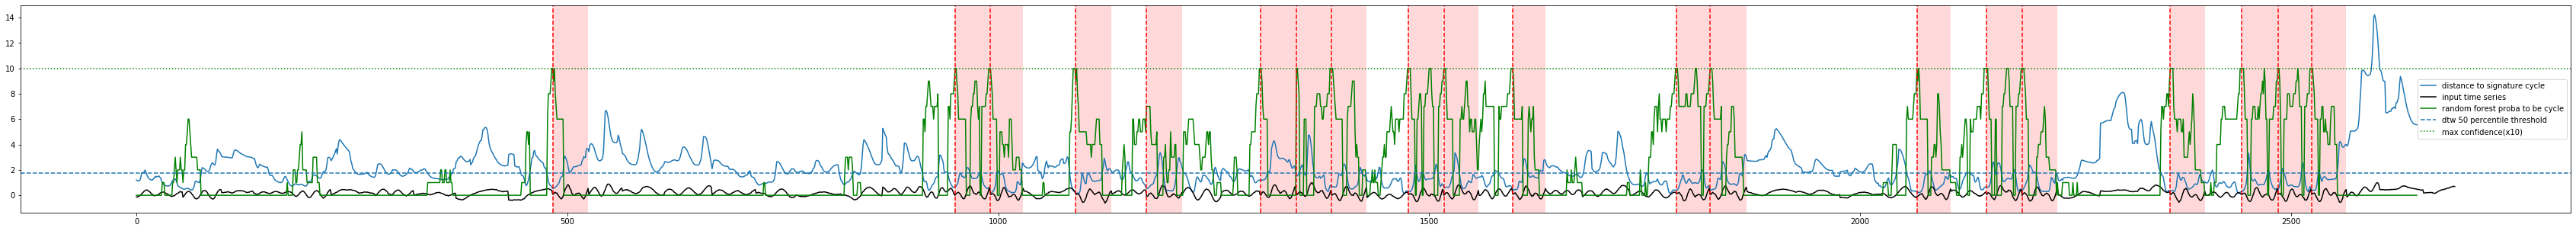

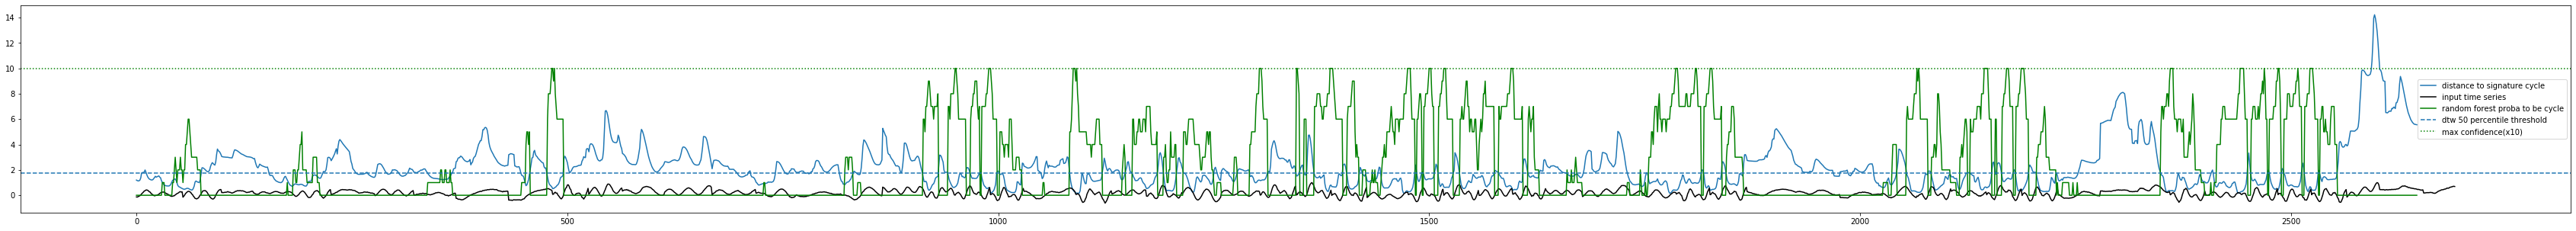

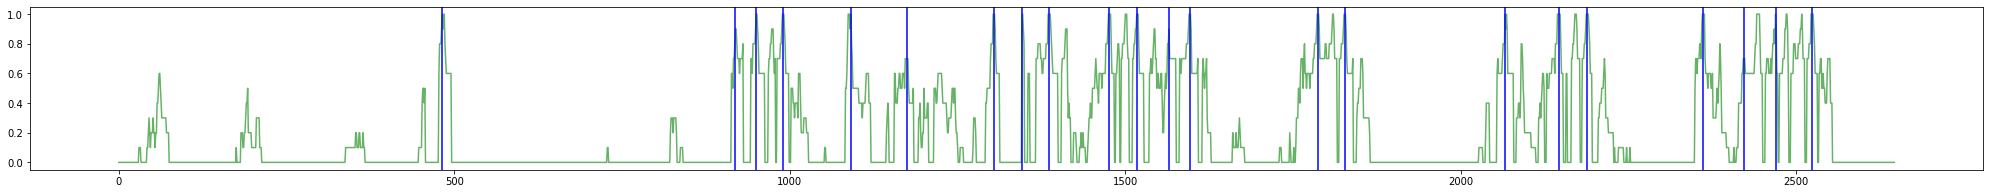

number of predicted cycles:  22
number of real cycles:  20
True Positive: 0.9
False Positive: 0.18181818181818182


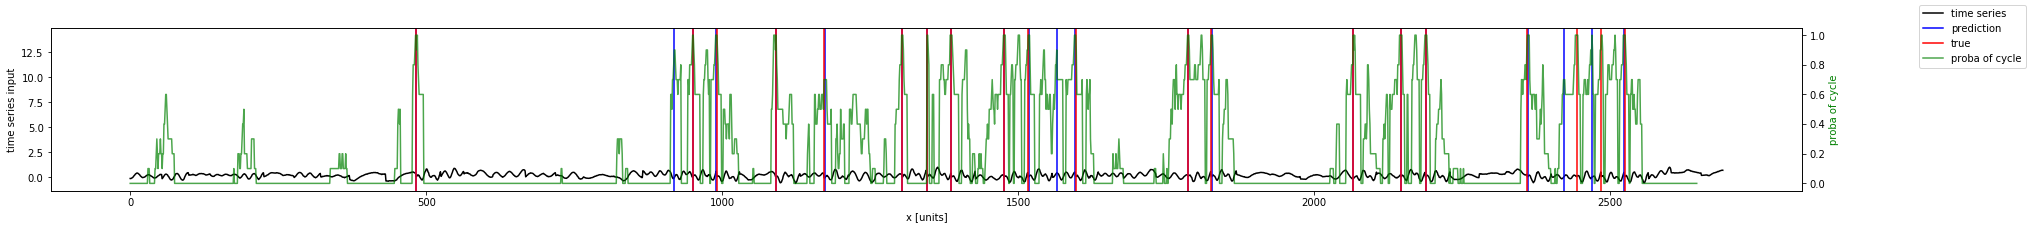

In [96]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'B_train_1.csv' 
test_file_name = 'B_test_1.csv'
target_name = 'A'
dtw_filter_percentile = 50

print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.7
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=10)
fp = false_positive(predicted_cycle, true_cycle, interval=10)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

## Cycle Pattern C

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...



Feature Extraction: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


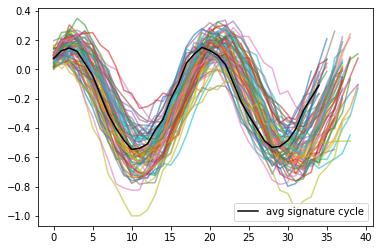

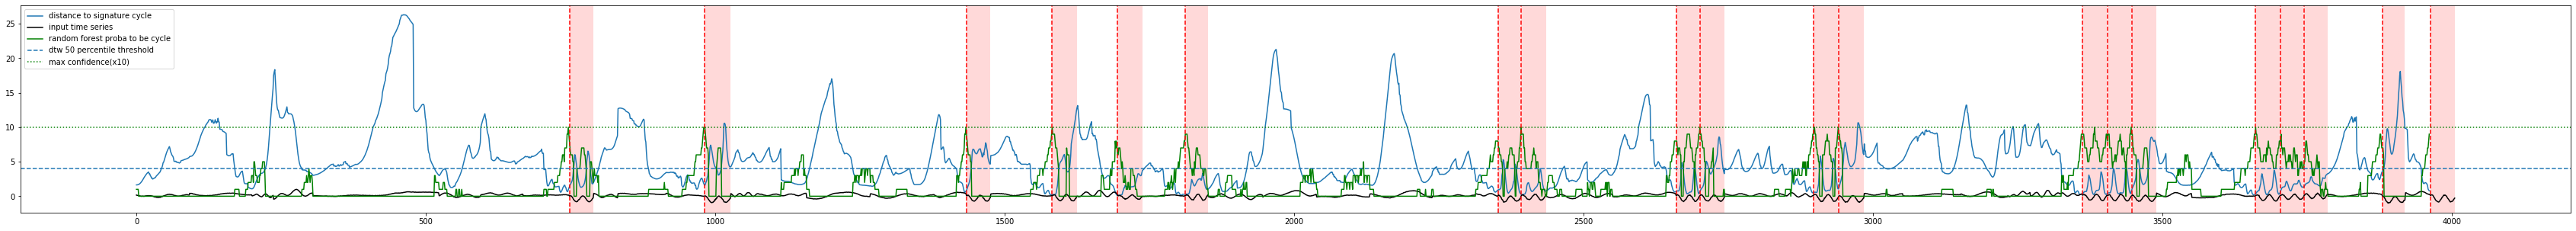

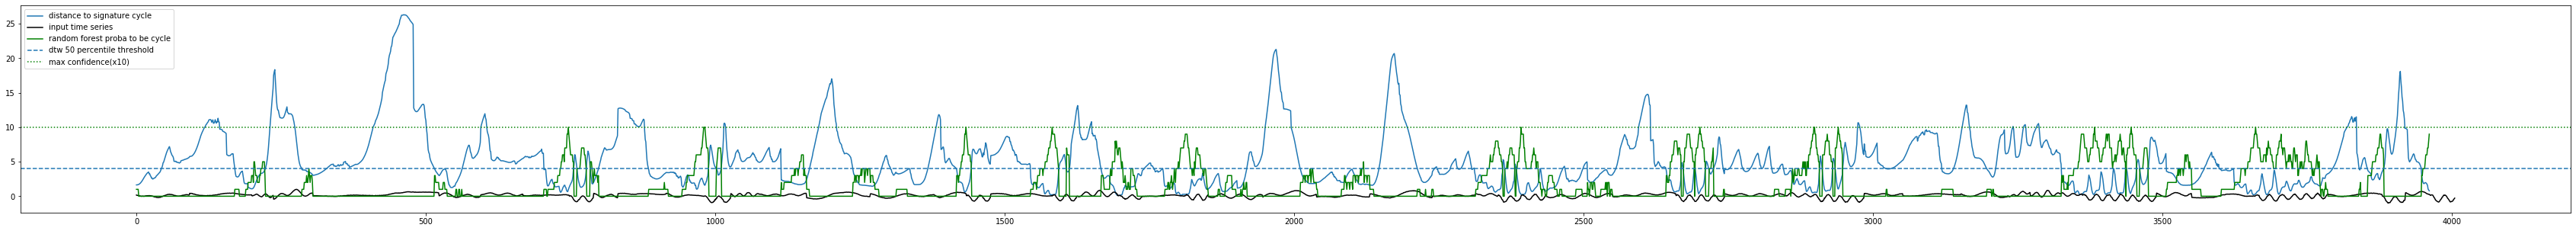

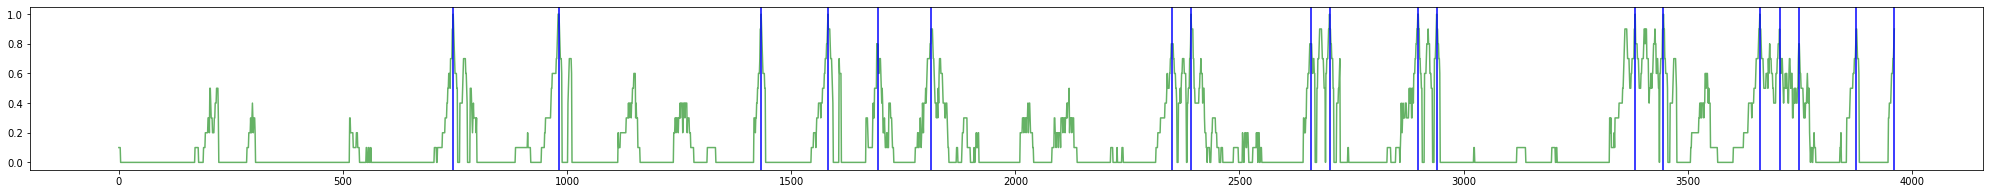

number of predicted cycles:  19
number of real cycles:  20
True Positive: 0.9
False Positive: 0.05263157894736842


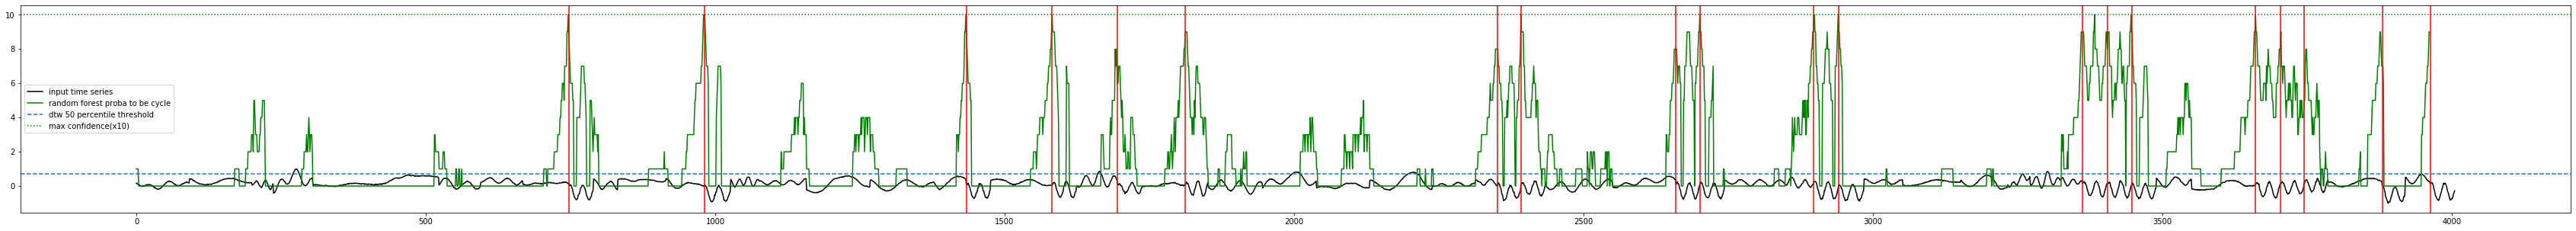

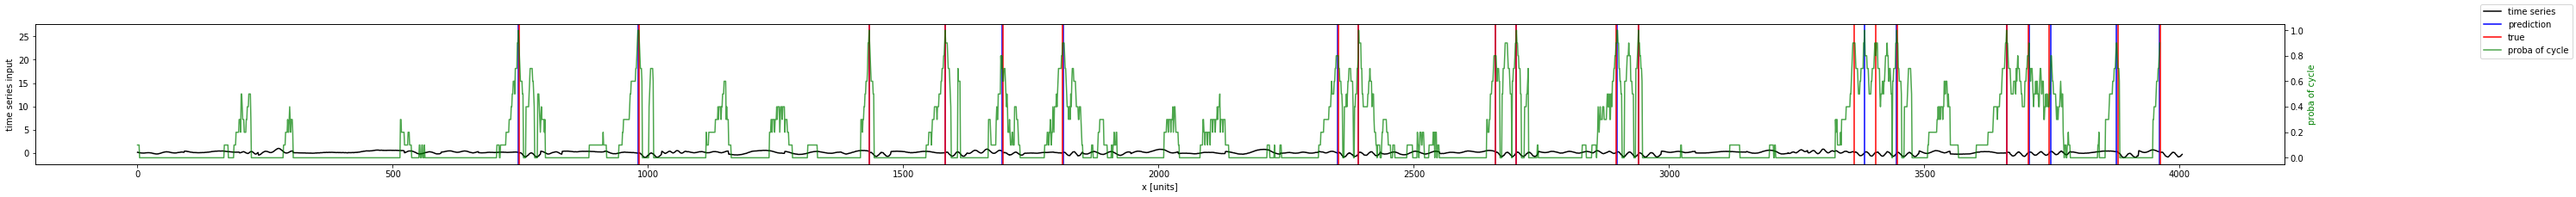

In [104]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'C_train_1.csv' 
test_file_name = 'C_test_1.csv'
target_name = 'A'
dtw_filter_percentile = 50

print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.7
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()


plt.figure(figsize=(60, 5))
#plt.plot(dist_list[:], label='distance to signature cycle')
plt.plot(ts_all[:], color='k', label='input time series')
plt.plot(np.array(proba_list) * 10, color='g', label='random forest proba to be cycle')
start = cycle_start.tolist()
end = cycle_end.tolist()
for i in cycle_start:
    plt.axvline(i, 0, 14,  color='r')
for i in range(len(start)):
    # alpha: 透明度
    # i+.5 -- 宽度
    plt.axvspan(start[i], end[i], facecolor='r', alpha=0.0)
plt.axhline(threshold, 0, 14, linestyle='--', label='dtw 50 percentile threshold')
plt.axhline(10, 0, 14, linestyle='dotted', color='g', label='max confidence(x10)')
plt.legend()

tp = true_positive(predicted_cycle, true_cycle, interval=10)
fp = false_positive(predicted_cycle, true_cycle, interval=10)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

## Cycle Pattern D

number of predicted cycles:  22
number of real cycles:  20
True Positive: 0.95
False Positive: 0.13636363636363635


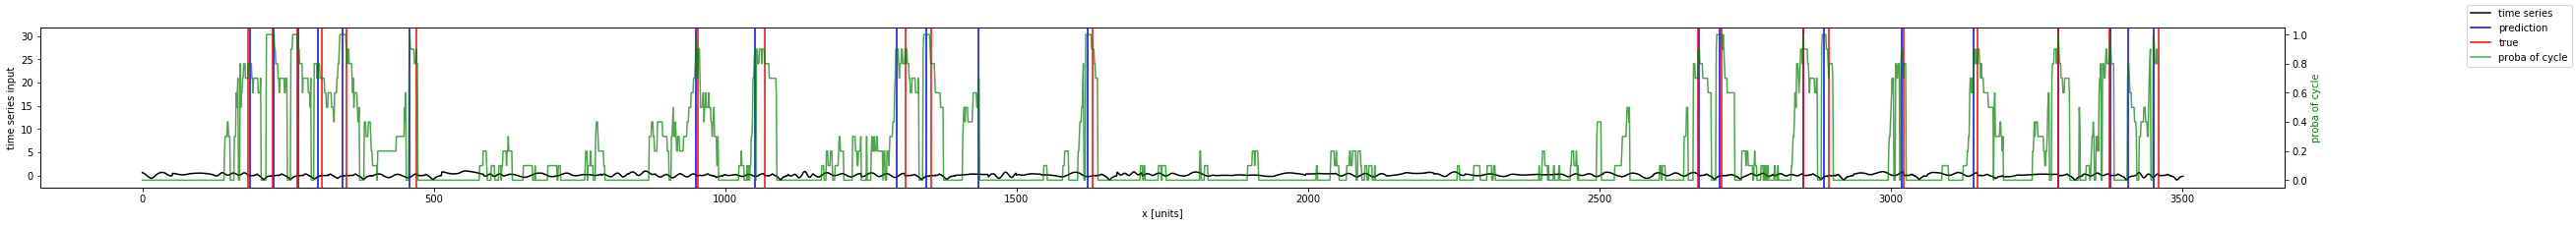

In [107]:
tp = true_positive(predicted_cycle, true_cycle, interval=15)
fp = false_positive(predicted_cycle, true_cycle, interval=15)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

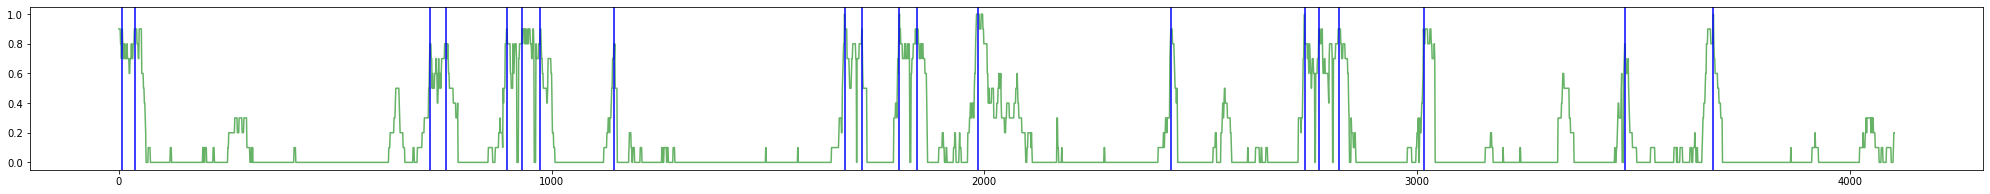

number of predicted cycles:  20
number of real cycles:  20
True Positive: 0.95
False Positive: 0.05


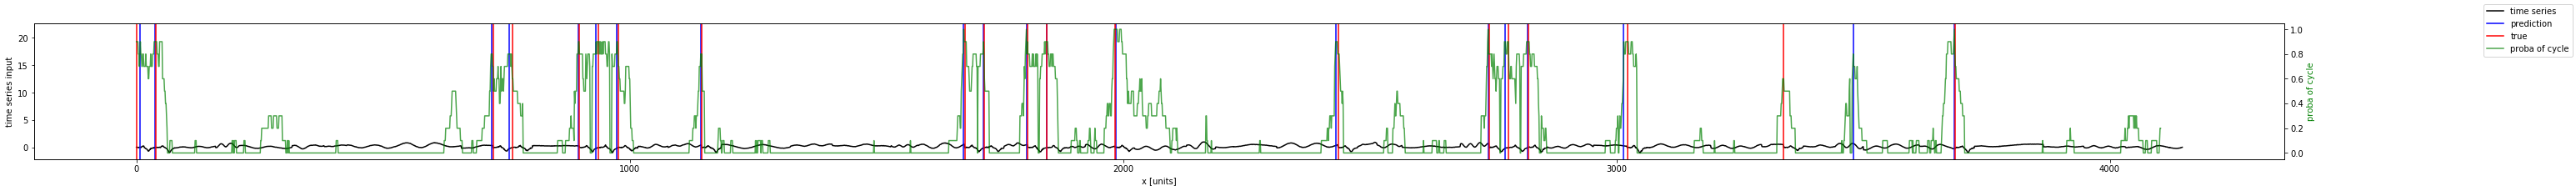

In [109]:
predicted_cycle = find_local_max(proba_list, 0.8, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=10)
fp = false_positive(predicted_cycle, true_cycle, interval=10)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

Find signature cycle from training set ...
Sliding window on testing time series ...
Calculating DTW distance
Looking for DTW distance threshold ...
percentile: 50
Converting time series to features by feature extraction...



Feature Extraction: 100%|██████████| 10/10 [00:10<00:00,  1.30it/s]

Training random forest classifier...
Validation Results -- grid search best parameters:  {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 10}
Calculating prediction... prediction type:  proba


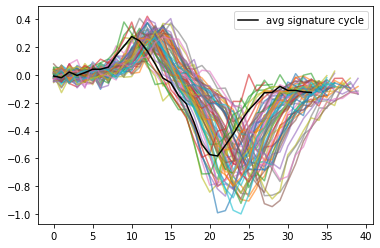

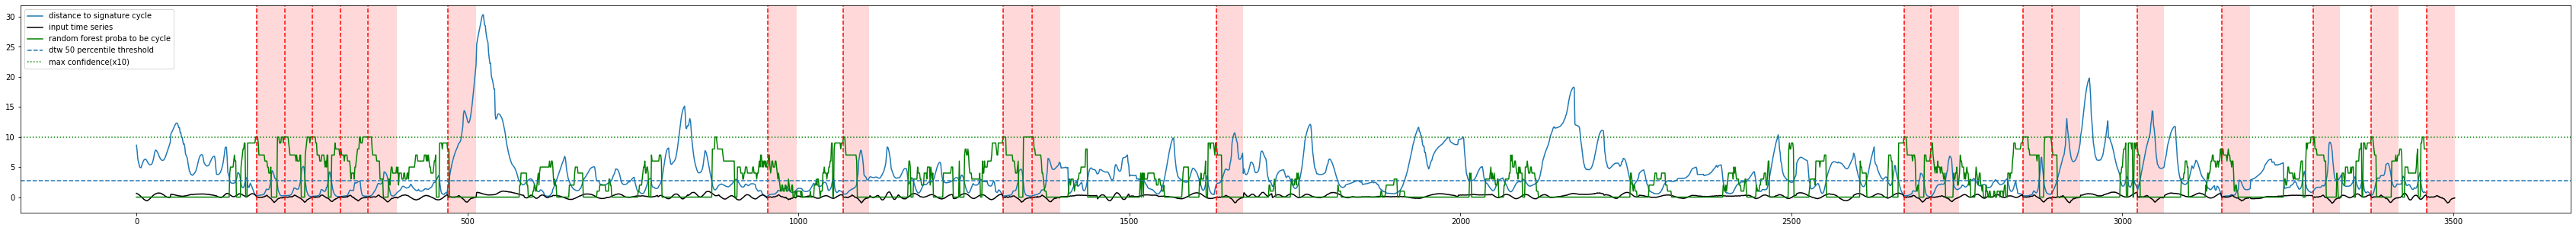

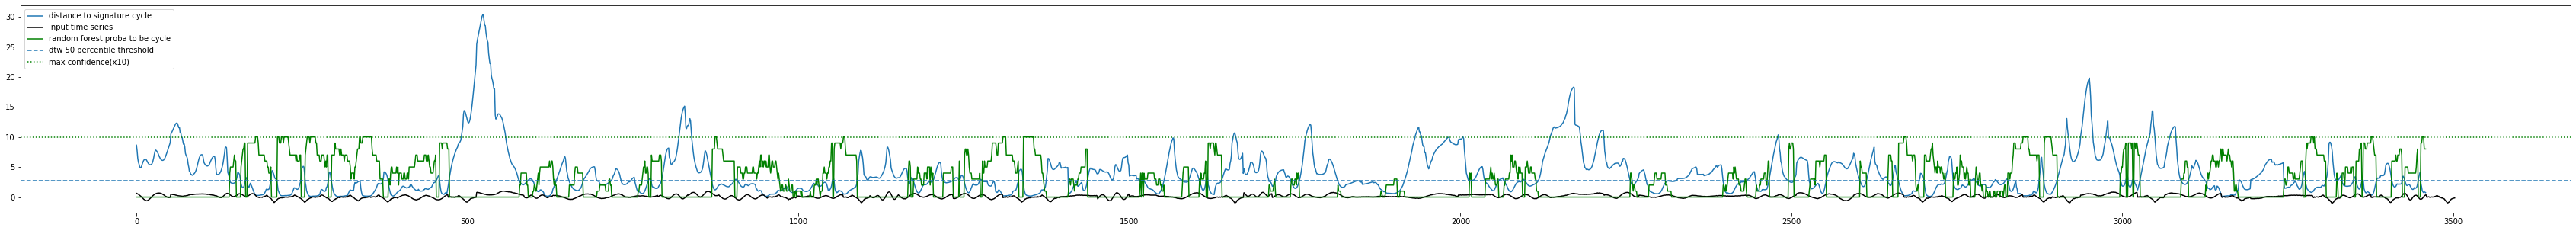

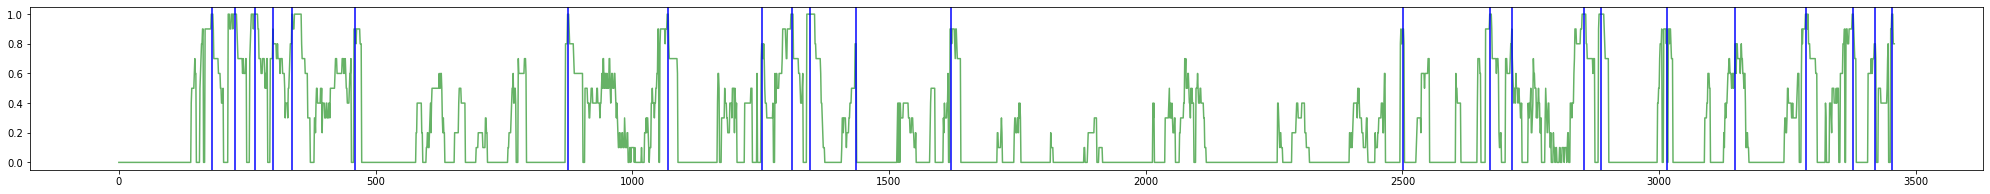

number of predicted cycles:  24
number of real cycles:  20
True Positive: 0.8
False Positive: 0.3333333333333333


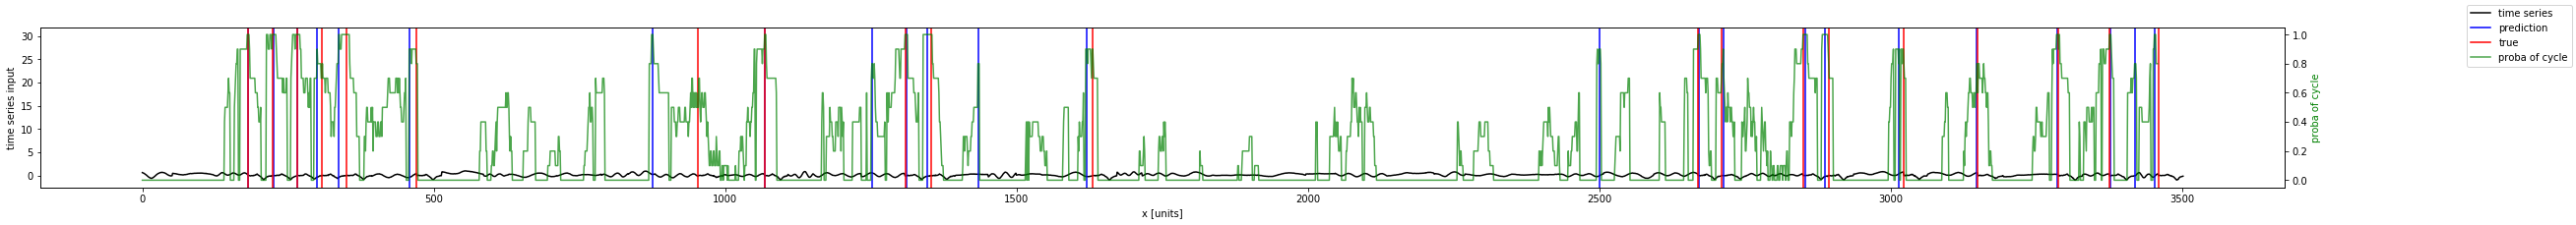

In [112]:
# Find good threshold on prediction cutting plane .. 
train_file_name = 'D_train_2.csv' 
test_file_name = 'D_test_2.csv'
target_name = 'B'
dtw_filter_percentile = 50

print('Find signature cycle from training set ...')
signature = find_train_set_signature(train_file_name, target_name)

print('Sliding window on testing time series ...')
print('Calculating DTW distance')
sliding_window_results = sliding_window_find_dist(test_file_name, target_name, signature)
ts_all = sliding_window_results[0]
all_window_contents = sliding_window_results[1]
dist_list, path_list = sliding_window_results[2], sliding_window_results[3]
cycle_start, cycle_end = sliding_window_results[4], sliding_window_results[5]

print('Looking for DTW distance threshold ...')
print('percentile:', dtw_filter_percentile)
suggested_threshold = find_dtw_threshold(dist_list, dtw_filter_percentile)

print('Converting time series to features by feature extraction...')
proba_list = sliding_window_classifier(all_window_contents, dist_list,
                                       train_file_name, target_name,
                                       suggested_threshold)

plot_result(dist_list, ts_all, proba_list,
            suggested_threshold, cycle_start, cycle_end)


threshold = 0.8
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=10)
fp = false_positive(predicted_cycle, true_cycle, interval=10)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

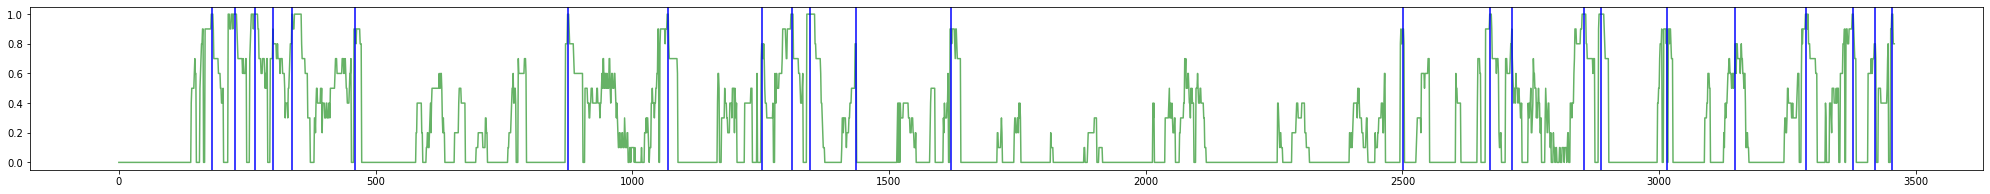

number of predicted cycles:  24
number of real cycles:  20
True Positive: 0.95
False Positive: 0.20833333333333334


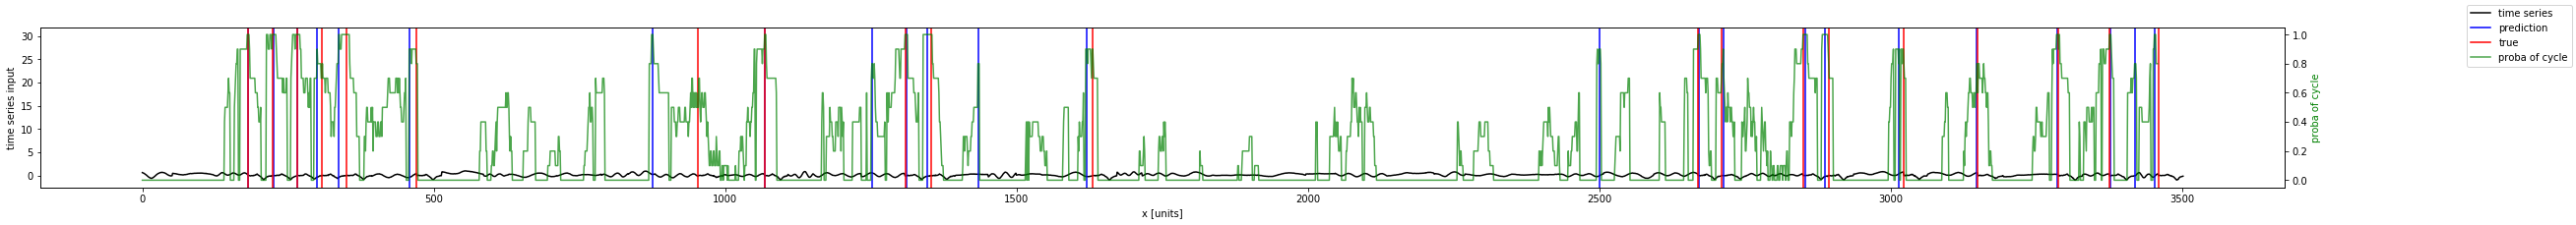

In [115]:
threshold = 0.8
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=15)
fp = false_positive(predicted_cycle, true_cycle, interval=15)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)

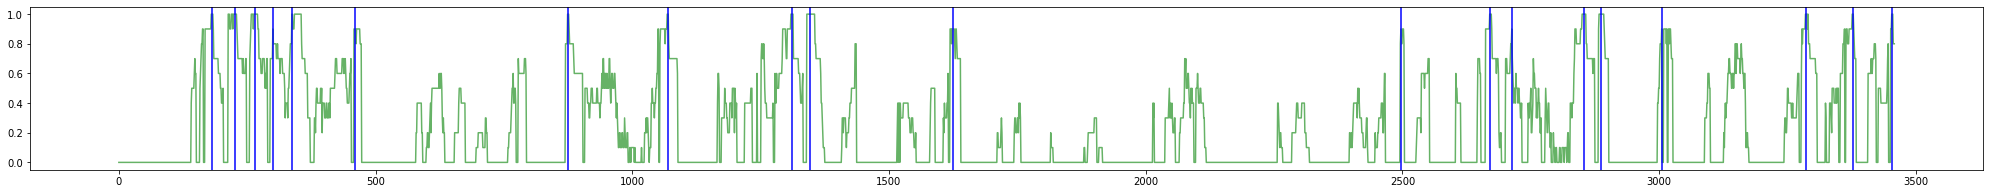

number of predicted cycles:  20
number of real cycles:  20
True Positive: 0.85
False Positive: 0.15


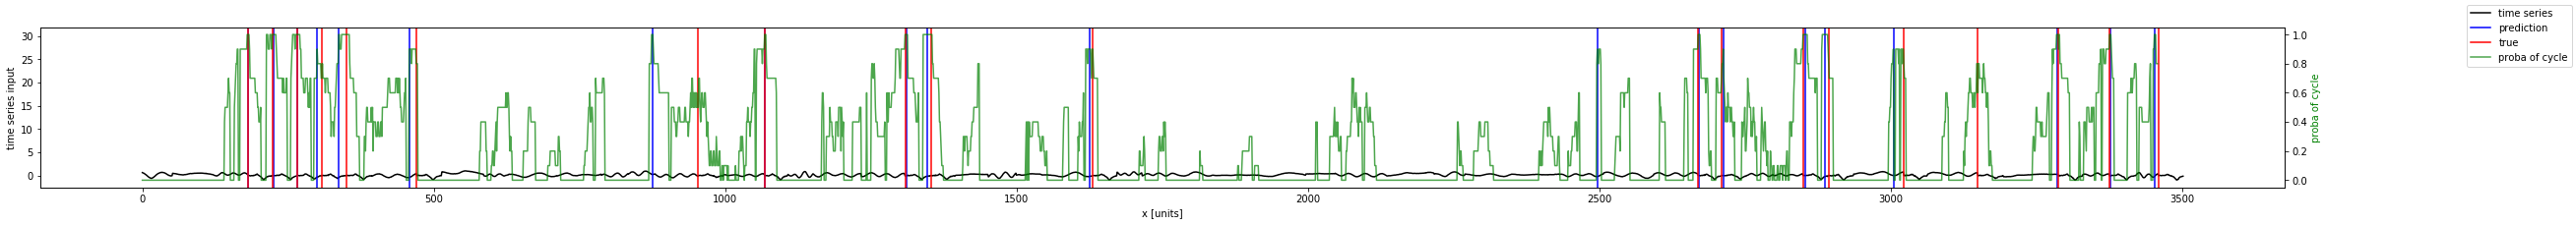

In [120]:
threshold = 0.9
range_filter = 30

predicted_cycle = find_local_max(proba_list, threshold, range_filter)
true_cycle = cycle_start.tolist()

tp = true_positive(predicted_cycle, true_cycle, interval=15)
fp = false_positive(predicted_cycle, true_cycle, interval=15)

plot_prediction_and_true(predicted_cycle, true_cycle, ts_all, proba_list)